<a href="https://colab.research.google.com/github/LCRazo/GPU-Utilization-and-Improvement-Project-/blob/main/BatchIncrease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Background

Below are the runnable codes to test GPU and GPU + Mixed Precision usage, as well as training times for GPU, GPU + Mixed Precision, and CPU. Change the runtime depending on what block you're running. Below are screenshots of what the program was being run on, the batch size, what factor the original batch was increased by, and the time it took to train. **GPU blocks here were run on the T4 GPU

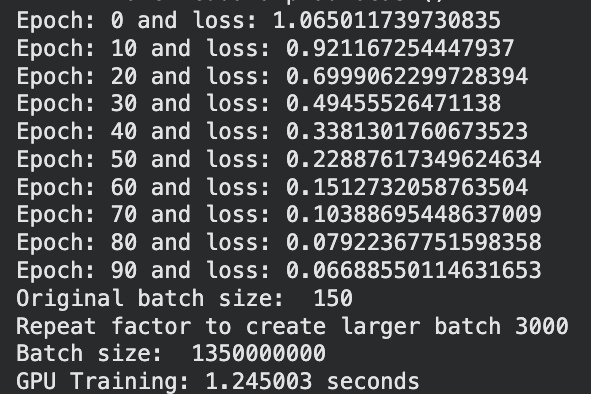
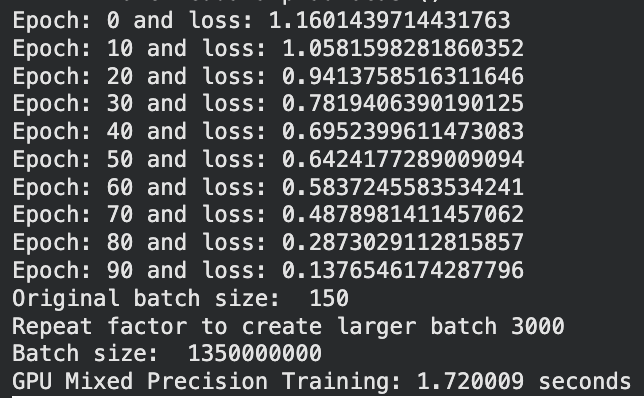

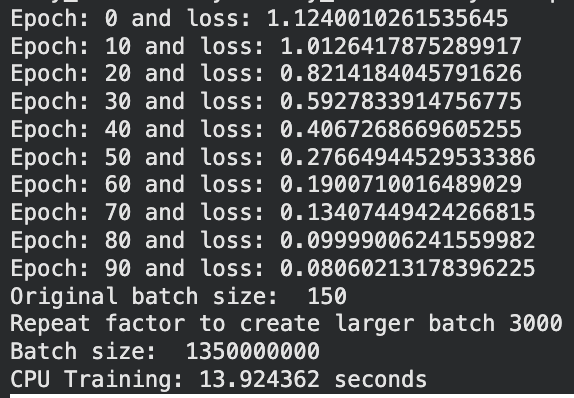

#GPU Mixed Precision

True
1
Current device: 0
Device name: NVIDIA A100-SXM4-40GB
Actual memory allocated: 0.079 GB
Epoch: 0 and loss: 1.07599937915802
Epoch: 10 and loss: 0.968551516532898
Epoch: 20 and loss: 0.8045617938041687
Epoch: 30 and loss: 0.7037157416343689
Epoch: 40 and loss: 0.6309173703193665
Epoch: 50 and loss: 0.5125890970230103
Epoch: 60 and loss: 0.313192218542099
Epoch: 70 and loss: 0.16329579055309296
Epoch: 80 and loss: 0.09727009385824203
Epoch: 90 and loss: 0.0737600177526474


/tmp/ipython-input-1819382774.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  my_df['variety'] = my_df['variety'].replace('Virginica', 2.0)


Original batch size:  150
Repeat factor to create larger batch 100
Batch size:  15000
GPU Mixed Precision Training: 0.192485 seconds
Current allocated memory: 59.40 MB
Reserved memory: 98.00 MB
Peak allocated memory: 60.30 MB


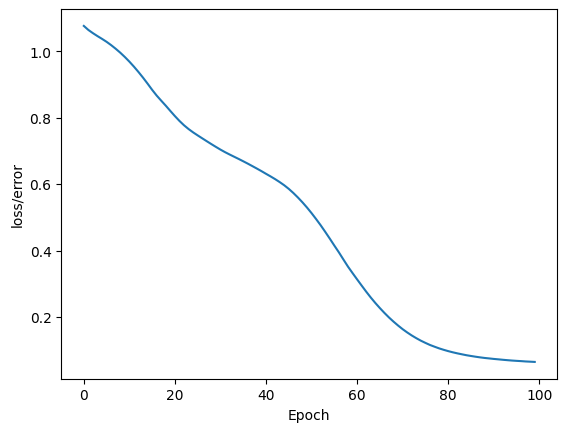

1.)  tensor([-4.2484,  4.3068,  1.3697], device='cuda:0') 	 1 	 1
2.)  tensor([-10.0219,   2.8832,   9.5831], device='cuda:0') 	 2 	 2
3.)  tensor([-3.2509,  5.2585, -0.6097], device='cuda:0') 	 1 	 1
4.)  tensor([-2.6589,  4.6709, -0.8538], device='cuda:0') 	 1 	 1
5.)  tensor([ 5.0866, -0.8465, -5.7860], device='cuda:0') 	 0 	 0
6.)  tensor([ 4.5733, -0.5547, -5.4008], device='cuda:0') 	 0 	 0
7.)  tensor([ 4.7779, -0.8130, -5.4423], device='cuda:0') 	 0 	 0
8.)  tensor([ 5.2691, -0.8161, -6.0289], device='cuda:0') 	 0 	 0
9.)  tensor([-8.4912,  3.1009,  7.5351], device='cuda:0') 	 2 	 2
10.)  tensor([ 5.0866, -0.8465, -5.7860], device='cuda:0') 	 0 	 0
11.)  tensor([-2.3353,  4.5103, -1.1151], device='cuda:0') 	 1 	 1
12.)  tensor([-4.0723,  4.7158,  0.8291], device='cuda:0') 	 1 	 1
13.)  tensor([ 5.5323, -0.8624, -6.3081], device='cuda:0') 	 0 	 0
14.)  tensor([-8.5159,  3.2021,  7.4808], device='cuda:0') 	 2 	 2
15.)  tensor([-4.1506,  4.9162,  0.7646], device='cuda:0') 	 1 	 1
1

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
# Mixed precision imports
from sklearn.model_selection import train_test_split
# %matplotlib inline

# Create a Model Class that inherits nn.Module
class Model(nn.Module):
  # Input layer (4 features of the flower) -->
  # Hidden Layer1 (number of neurons) -->
  # H2 (n) -->
  # output (3 classes of iris flowers)
  def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
    super().__init__() # instantiate our nn.Module
    self.fc1 = nn.Linear(in_features, h1).cuda(0)
    self.fc2 = nn.Linear(h1, h2).cuda(0)
    self.out = nn.Linear(h2, out_features).cuda(0)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x

print(torch.cuda.is_available()) # This tells me if CUDA-enabled GPU is detected and PyTorch is configured to use it
print(torch.cuda.device_count()) # Returns the available GPUs

if torch.cuda.is_available():
  print(f"Current device: {torch.cuda.current_device()}")
  print(f"Device name: {torch.cuda.get_device_name(0)}")
  torch.cuda.reset_peak_memory_stats()
  fraction = 0.002
  torch.cuda.set_per_process_memory_fraction(fraction, 0)

  total_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3

  actual_memory_allocated = total_memory_gb * fraction

  print(f"Actual memory allocated: {actual_memory_allocated:.3f} GB")

  # print(stats)

  # main code
  # Pick a manual seed for randomization
  torch.cuda.manual_seed(41)
  # Create an instance of model
  model = Model().cuda(0)

  url = 'https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv'
  my_df = pd.read_csv(url)


  my_df.tail() # This will display the last 5 rows

  # Change last column from strings to integers
  my_df['variety'] = my_df['variety'].replace('Setosa', 0.0)
  my_df['variety'] = my_df['variety'].replace('Versicolor', 1.0)
  my_df['variety'] = my_df['variety'].replace('Virginica', 2.0)

  # Train Test Split!  Set X, y
  X = my_df.drop('variety', axis=1)
  y = my_df['variety']

  # Convert these to numpy arrays
  X = X.values
  y = y.values


  #To increase batch
  repeat_factor = 100
  X = np.tile(X, (repeat_factor, 1))
  y = np.tile(y, repeat_factor)

  # Train Test Split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

  # Convert X features to float tensors
  X_train = torch.FloatTensor(X_train).cuda(0)
  X_test = torch.FloatTensor(X_test).cuda(0)

  # Convert y labels to tensors long
  y_train = torch.LongTensor(y_train).cuda(0)
  y_test = torch.LongTensor(y_test).cuda(0)

  # Set the criterion of model to measure the error, how far off the predictions are from the data
  criterion = nn.CrossEntropyLoss().cuda(0)
  # Choose Adam Optimizer, lr = learning rate (if error doesn't go down after a bunch of iterations (epochs), lower our learning rate)
  scaler = torch.amp.GradScaler("cuda")
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  # Train our model!
  # Epochs? (one run thru all the training data in our network)
  epochs = 100
  losses = []

#to time
  torch.cuda.synchronize()
  start = time.time()
################

  for i in range(epochs):
    # Go forward and get a prediction
    # y_pred = model.forward(X_train) # Get predicted results

    # Measure the loss/error, gonna be high at first
    # loss = criterion(y_pred, y_train) # predicted values vs the y_train
    optimizer.zero_grad()
    # This is for mixed precision
    with torch.amp.autocast("cuda"):
      # Go forward and get a prediction
      y_pred = model.forward(X_train) # Get predicted results
      # Measure the loss/error, gonna be high at first
      loss = criterion(y_pred, y_train) # predicted values vs the y_train

    # Keep Track of our losses
    lossCPU = loss.cpu()
    losses.append(lossCPU.detach().numpy())

    # print every 10 epoch
    if i % 10 == 0:
      print(f'Epoch: {i} and loss: {loss}')

    # Do some back propagation: take the error rate of forward propagation and feed it back
    # thru the network to fine tune the weights
    # Backpropagation with mixed precision

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

  ########PRINT TIME
  torch.cuda.synchronize()
  end = time.time()
  print(f"Original batch size: ", my_df.shape[0])
  print(f"Repeat factor to create larger batch", repeat_factor)
  print(f"Batch size: ", X.shape[0])
  print(f"GPU Mixed Precision Training: {end - start:.6f} seconds")
  # Get current allocated memory
  allocated_memory = torch.cuda.memory_allocated(0)
  print(f"Current allocated memory: {allocated_memory / (1024**2):.2f} MB")

  # Get reserved memory
  reserved_memory = torch.cuda.memory_reserved(0)
  print(f"Reserved memory: {reserved_memory / (1024**2):.2f} MB")

  # Get peak allocated memory
  peak_allocated_memory = torch.cuda.max_memory_allocated(0)
  print(f"Peak allocated memory: {peak_allocated_memory / (1024**2):.2f} MB")

  stats = torch.cuda.memory_stats()

  # Graph it out!
  plt.plot(range(epochs), losses)
  plt.ylabel("loss/error")
  plt.xlabel('Epoch')
  plt.show()

  # Evaluate Model on Test Data Set (validate model on test set)
  with torch.no_grad():  # Basically turn off back propogation
    y_eval = model.forward(X_test) # X_test are features from our test set, y_eval will be predictions
    loss = criterion(y_eval, y_test) # Find the loss or error

  correct = 0
  with torch.no_grad():
    for i, data in enumerate(X_test):
      y_val = model.forward(data)

      if y_test[i] == 0:
        x = "Setosa"
      elif y_test[i] == 1:
        x = 'Versicolor'
      else:
        x = 'Virginica'


      # Will tell us what type of flower class our network thinks it is
      print(f'{i+1}.)  {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}')

      # Correct or not
      if y_val.argmax().item() == y_test[i]:
        correct +=1

  print(f'We got {correct} correct!')

  stats = torch.cuda.memory_stats()

  print(torch.cuda.memory_summary(device=0, abbreviated=True))



#GPU BLOCK

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
# Mixed precision imports
from sklearn.model_selection import train_test_split
# %matplotlib inline

# Create a Model Class that inherits nn.Module
class Model(nn.Module):
  # Input layer (4 features of the flower) -->
  # Hidden Layer1 (number of neurons) -->
  # H2 (n) -->
  # output (3 classes of iris flowers)
  def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
    super().__init__() # instantiate our nn.Module
    self.fc1 = nn.Linear(in_features, h1).cuda(0)
    self.fc2 = nn.Linear(h1, h2).cuda(0)
    self.out = nn.Linear(h2, out_features).cuda(0)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x

print(torch.cuda.is_available()) # This tells me if CUDA-enabled GPU is detected and PyTorch is configured to use it
print(torch.cuda.device_count()) # Returns the available GPUs

if torch.cuda.is_available():
  print(f"Current device: {torch.cuda.current_device()}")
  print(f"Device name: {torch.cuda.get_device_name(0)}")
  torch.cuda.reset_peak_memory_stats()
  fraction = 0.002
  torch.cuda.set_per_process_memory_fraction(fraction, 0)

  total_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3

  actual_memory_allocated = total_memory_gb * fraction

  print(f"Actual memory allocated: {actual_memory_allocated:.3f} GB")

  #print(stats)

  # main code
  # Pick a manual seed for randomization
  torch.cuda.manual_seed(41)
  # Create an instance of model
  model = Model().cuda(0)

  url = 'https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv'
  my_df = pd.read_csv(url)


  my_df.tail() # This will display the last 5 rows

  # Change last column from strings to integers
  my_df['variety'] = my_df['variety'].replace('Setosa', 0.0)
  my_df['variety'] = my_df['variety'].replace('Versicolor', 1.0)
  my_df['variety'] = my_df['variety'].replace('Virginica', 2.0)

  # Train Test Split!  Set X, y
  X = my_df.drop('variety', axis=1)
  y = my_df['variety']

  # Convert these to numpy arrays
  X = X.values
  y = y.values

  #TO REPEAT BATCH
  # Repeat the dataset 1000× to increase size from 150 → 150,000
  repeat_factor = 100
  X = np.tile(X, (repeat_factor, 1))   # shape becomes (150000, 4)
  y = np.tile(y, repeat_factor)        # shape becomes (150000,)


  # Train Test Split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

  # Convert X features to float tensors
  X_train = torch.FloatTensor(X_train).cuda(0)
  X_test = torch.FloatTensor(X_test).cuda(0)

  # Convert y labels to tensors long
  y_train = torch.LongTensor(y_train).cuda(0)
  y_test = torch.LongTensor(y_test).cuda(0)

  # Set the criterion of model to measure the error, how far off the predictions are from the data
  criterion = nn.CrossEntropyLoss().cuda(0)
  # Choose Adam Optimizer, lr = learning rate (if error doesn't go down after a bunch of iterations (epochs), lower our learning rate)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  # Train our model!
  # Epochs? (one run thru all the training data in our network)
  epochs = 100
  losses = []

#ADDED TO TIME
  torch.cuda.synchronize()
  start = time.time()
################

  for i in range(epochs):
    # Go forward and get a prediction
    # y_pred = model.forward(X_train) # Get predicted results

    # Measure the loss/error, gonna be high at first
    # loss = criterion(y_pred, y_train) # predicted values vs the y_train
    optimizer.zero_grad()
    # This is for mixed precision
    y_pred = model.forward(X_train) # Get predicted results
    # Measure the loss/error, gonna be high at first
    loss = criterion(y_pred, y_train) # predicted values vs the y_train

    # Keep Track of our losses
    lossCPU = loss.cpu()
    losses.append(lossCPU.detach().numpy())

    # print every 10 epoch
    if i % 10 == 0:
      print(f'Epoch: {i} and loss: {loss}')

    # Do some back propagation: take the error rate of forward propagation and feed it back
    # thru the network to fine tune the weights

    loss.backward()
    optimizer.step()

  ########PRINT TIME
  torch.cuda.synchronize()
  end = time.time()
  print(f"Original batch size: ", my_df.shape[0])
  print(f"Repeat factor to create larger batch", repeat_factor)
  print(f"Batch size: ", X.shape[0])
  print(f"GPU Training: {end - start:.6f} seconds")
  # Get current allocated memory
  allocated_memory = torch.cuda.memory_allocated(0)
  print(f"Current allocated memory: {allocated_memory / (1024**2):.2f} MB")

  # Get reserved memory
  reserved_memory = torch.cuda.memory_reserved(0)
  print(f"Reserved memory: {reserved_memory / (1024**2):.2f} MB")

  # Get peak allocated memory
  peak_allocated_memory = torch.cuda.max_memory_allocated(0)
  print(f"Peak allocated memory: {peak_allocated_memory / (1024**2):.2f} MB")

  stats = torch.cuda.memory_stats()

  # Graph it out!
  plt.plot(range(epochs), losses)
  plt.ylabel("loss/error")
  plt.xlabel('Epoch')
  plt.show()

  # Evaluate Model on Test Data Set (validate model on test set)
  with torch.no_grad():  # Basically turn off back propogation
    y_eval = model.forward(X_test) # X_test are features from our test set, y_eval will be predictions
    loss = criterion(y_eval, y_test) # Find the loss or error

  correct = 0
  with torch.no_grad():
    for i, data in enumerate(X_test):
      y_val = model.forward(data)

      if y_test[i] == 0:
        x = "Setosa"
      elif y_test[i] == 1:
        x = 'Versicolor'
      else:
        x = 'Virginica'


      # Will tell us what type of flower class our network thinks it is
      print(f'{i+1}.)  {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}')

      # Correct or not
      if y_val.argmax().item() == y_test[i]:
        correct +=1

  print(f'We got {correct} correct!')

  stats = torch.cuda.memory_stats()

  print(torch.cuda.memory_summary(device=0, abbreviated=True))



True
1
Current device: 0
Device name: NVIDIA A100-SXM4-40GB
Actual memory allocated: 0.079 GB
OrderedDict({'active.all.allocated': 19530081, 'active.all.current': 97, 'active.all.freed': 19529984, 'active.all.peak': 104, 'active.large_pool.allocated': 19431, 'active.large_pool.current': 9, 'active.large_pool.freed': 19422, 'active.large_pool.peak': 9, 'active.small_pool.allocated': 19510650, 'active.small_pool.current': 88, 'active.small_pool.freed': 19510562, 'active.small_pool.peak': 95, 'active_bytes.all.allocated': 93532207616, 'active_bytes.all.current': 61862400, 'active_bytes.all.freed': 93470345216, 'active_bytes.all.peak': 62328320, 'active_bytes.large_pool.allocated': 80963144704, 'active_bytes.large_pool.current': 59712000, 'active_bytes.large_pool.freed': 80903432704, 'active_bytes.large_pool.peak': 59712000, 'active_bytes.small_pool.allocated': 12569062912, 'active_bytes.small_pool.current': 2150400, 'active_bytes.small_pool.freed': 12566912512, 'active_bytes.small_pool.pe

/tmp/ipython-input-3287134474.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  my_df['variety'] = my_df['variety'].replace('Virginica', 2.0)


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 38.95 GiB is free. Process 22431 has 614.00 MiB memory in use. 81.01 MiB allowed; Of the allocated memory 60.38 MiB is allocated by PyTorch, and 37.62 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#CPU BLOCK

/tmp/ipython-input-3450737451.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  my_df['variety'] = my_df['variety'].replace('Virginica', 2.0)


Epoch: 0 and loss: 1.124016284942627
Epoch: 10 and loss: 1.0128003358840942
Epoch: 20 and loss: 0.8220687508583069
Epoch: 30 and loss: 0.594072163105011
Epoch: 40 and loss: 0.40852421522140503
Epoch: 50 and loss: 0.2785325050354004
Epoch: 60 and loss: 0.19123239815235138
Epoch: 70 and loss: 0.13487547636032104
Epoch: 80 and loss: 0.10042402148246765
Epoch: 90 and loss: 0.08077891916036606
Original batch size:  150
Repeat factor to create larger batch 1000
Batch size:  150000
CPU Training: 4.588428 seconds


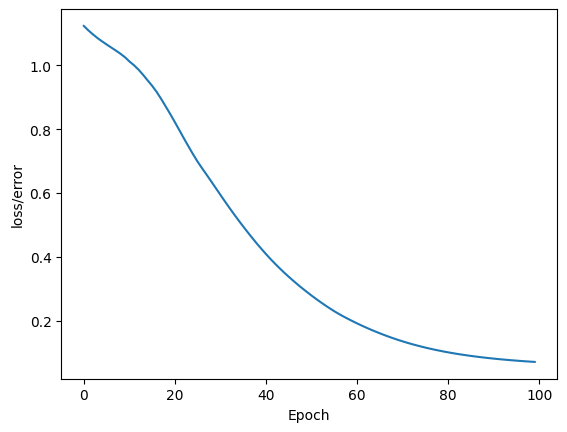

Streaming output truncated to the last 5000 lines.
25005.)  tensor([-4.8062,  5.8921,  2.7818]) 	 1 	 1
25006.)  tensor([ 4.9393, -2.5818, -3.0880]) 	 0 	 0
25007.)  tensor([-7.6505,  4.1176,  9.6139]) 	 2 	 2
25008.)  tensor([ 5.0787, -2.6942, -3.1612]) 	 0 	 0
25009.)  tensor([-5.7683,  4.9062,  5.5240]) 	 2 	 2
25010.)  tensor([-6.8614,  4.3226,  8.0613]) 	 2 	 2
25011.)  tensor([-7.2868,  4.6734,  8.3745]) 	 2 	 2
25012.)  tensor([ 4.7209, -2.3768, -2.9933]) 	 0 	 0
25013.)  tensor([-7.8382,  4.6605,  9.3091]) 	 2 	 2
25014.)  tensor([-4.3485,  5.4482,  2.5211]) 	 1 	 1
25015.)  tensor([ 4.6385, -2.3270, -2.9478]) 	 0 	 0
25016.)  tensor([-5.7253,  4.8320,  5.5441]) 	 2 	 2
25017.)  tensor([ 4.7685, -2.3932, -3.0335]) 	 0 	 0
25018.)  tensor([ 4.3800, -2.0766, -2.8317]) 	 0 	 0
25019.)  tensor([ 4.8659, -2.5079, -3.0597]) 	 0 	 0
25020.)  tensor([ 4.7209, -2.3768, -2.9933]) 	 0 	 0
25021.)  tensor([ 4.5611, -2.2279, -2.9231]) 	 0 	 0
25022.)  tensor([-7.6319,  3.6881, 10.0533]) 	 2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import time
# %matplotlib inline

# Create a Model Class that inherits nn.Module
class Model(nn.Module):
  # Input layer (4 features of the flower) -->
  # Hidden Layer1 (number of neurons) -->
  # H2 (n) -->
  # output (3 classes of iris flowers)
  def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
    super().__init__() # instantiate our nn.Module
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x


# main code
# Pick a manual seed for randomization
torch.manual_seed(41)
# Create an instance of model
model = Model()

url = 'https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv'
my_df = pd.read_csv(url)


my_df.tail() # This will display the last 5 rows

# Change last column from strings to integers
my_df['variety'] = my_df['variety'].replace('Setosa', 0.0)
my_df['variety'] = my_df['variety'].replace('Versicolor', 1.0)
my_df['variety'] = my_df['variety'].replace('Virginica', 2.0)

# Train Test Split!  Set X, y
X = my_df.drop('variety', axis=1)
y = my_df['variety']

# Convert these to numpy arrays
X = X.values
y = y.values

#TO REPEAT BATCH
# Repeat the dataset 1000× to increase size from 150 → 150,000
repeat_factor = 1000
X = np.tile(X, (repeat_factor, 1))   # shape becomes (150000, 4)
y = np.tile(y, repeat_factor)        # shape becomes (150000,)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Convert X features to float tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Convert y labels to tensors long
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Set the criterion of model to measure the error, how far off the predictions are from the data
criterion = nn.CrossEntropyLoss()
# Choose Adam Optimizer, lr = learning rate (if error doesn't go down after a bunch of iterations (epochs), lower our learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train our model!
# Epochs? (one run thru all the training data in our network)
epochs = 100
losses = []

#TO TIME
start = time.time()
#########

for i in range(epochs):
  # Go forward and get a prediction
  y_pred = model.forward(X_train) # Get predicted results

  # Measure the loss/error, gonna be high at first
  loss = criterion(y_pred, y_train) # predicted values vs the y_train

  # Keep Track of our losses

  losses.append(loss.detach().numpy())

  # print every 10 epoch
  if i % 10 == 0:
    print(f'Epoch: {i} and loss: {loss}')

  # Do some back propagation: take the error rate of forward propagation and feed it back
  # thru the network to fine tune the weights
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

#PRINT TIME
end = time.time()
print(f"Original batch size: ", my_df.shape[0])
print(f"Repeat factor to create larger batch", repeat_factor)
print(f"Batch size: ", X.shape[0])
print(f"CPU Training: {end - start:.6f} seconds")


        # Graph it out!
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.show()

# Evaluate Model on Test Data Set (validate model on test set)
with torch.no_grad():  # Basically turn off back propogation
  y_eval = model.forward(X_test) # X_test are features from our test set, y_eval will be predictions
  loss = criterion(y_eval, y_test) # Find the loss or error

correct = 0
with torch.no_grad():
  for i, data in enumerate(X_test):
    y_val = model.forward(data)

    if y_test[i] == 0:
      x = "Setosa"
    elif y_test[i] == 1:
      x = 'Versicolor'
    else:
      x = 'Virginica'


    # Will tell us what type of flower class our network thinks it is
    print(f'{i+1}.)  {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}')

    # Correct or not
    if y_val.argmax().item() == y_test[i]:
      correct +=1

print(f'We got {correct} correct!')

# Get current allocated memory
allocated_memory = torch.cuda.memory_allocated(0)
print(f"Current allocated memory: {allocated_memory / (1024**2):.2f} MB")

# Get reserved memory
reserved_memory = torch.cuda.memory_reserved(0)
print(f"Reserved memory: {reserved_memory / (1024**2):.2f} MB")

# Get peak allocated memory
peak_allocated_memory = torch.cuda.max_memory_allocated(0)
print(f"Peak allocated memory: {peak_allocated_memory / (1024**2):.2f} MB")
# print(torch.cuda.memory_summary(device=0, abbreviated=True))




#Shape Tests + Miscellaneous

In [ ]:
X.shape

(450000, 4)

In [ ]:
my_df.shape

(150, 5)

In [ ]:
X_train.shape

torch.Size([360000, 4])

In [ ]:
X_test.shape

torch.Size([90000, 4])

In [ ]:
repeat_factor * X.shape[0]

3750000000

In [16]:
import torch
fraction = 0.001
torch.cuda.set_per_process_memory_fraction(fraction, 0)

total_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3

actual_memory_allocated = total_memory_gb * fraction

print(f"Actual memory allocated: {actual_memory_allocated:.3f} GB")

Actual memory allocated: 0.040 GB
